In [83]:
%matplotlib inline
import random 

import gym
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn
from torch.autograd import Variable

from utils import grid_from_state, process_state
from tutorial import select_action, calculate_epsilon
from memory import ReplayMemory
from atari_wrappers import wrap_deepmind

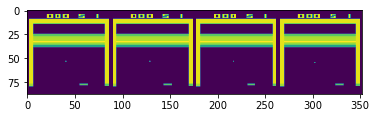

In [2]:
env = gym.make('Breakout-v0')
env = wrap_deepmind(env, frame_stack=True)
_ = env.reset()
action = env.action_space.sample()
state, reward, _, _ = env.step(action)  # carry out action/observe reward
next_state, _, _, _ = env.step(env.action_space.sample())  # carry out action/observe reward

plt.imshow(grid_from_state(state));

## distributional Q netowork will output a q value distribution for each action

![dist-q](assets/distributional-q.png)

In [6]:
class C51(nn.Module):
    """
    C51 architecture from "A Distributional Perspective on Reinforcement Learning"
    https://arxiv.org/pdf/1707.06887.pdf
    https://arxiv.org/pdf/1710.10044.pdf
    outputs value distributions with 51 support values
    """
    def __init__(self, num_actions, num_atoms=51):
        super(C51, self).__init__()
        self.num_actions = num_actions
        self.num_atoms = num_atoms
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions * num_atoms)

    def forward(self, state):
        x = F.relu(self.conv1(state))  # (20, 20, 32)
        x = F.relu(self.conv2(x))  # (9, 9, 64)
        x = F.relu(self.conv3(x))  # (7, 7, 64)
        x = x.view(x.size(0), -1)  # flatten (7*7*64)
        x = F.relu(self.fc4(x))  # (512)
        x = self.fc5(x)
        q_distributions = x.view(-1, self.num_actions, self.num_atoms) # (num_actions) q value for each action
        return F.softmax(q_distributions, dim=2)

In [16]:
c51 = C51(env.action_space.n)
qdists = c51(Variable(process_state(state)))

## Value distribution for action 0
- we are rightfully uncertain

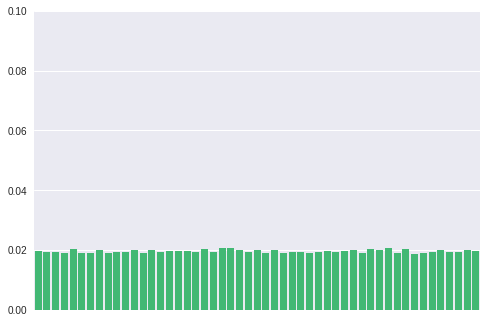

In [12]:
import seaborn as sns
g = sns.barplot(torch.arange(0, 51).numpy(), qdists.squeeze(0)[0].data.numpy(), color="#2ecc71")
g.set(xticklabels=[])
g.set_ylim(0, 0.1);

## selecting actions
- project q_dists onto reward distribution, sum their values 

In [81]:
num_atoms = 51 # 51 for C51
v_max = 10
v_min = -10
delta_z = (v_max - v_min) / float(num_atoms - 1)
projection_dist = torch.Tensor([v_min + i * delta_z for i in range(num_atoms)])

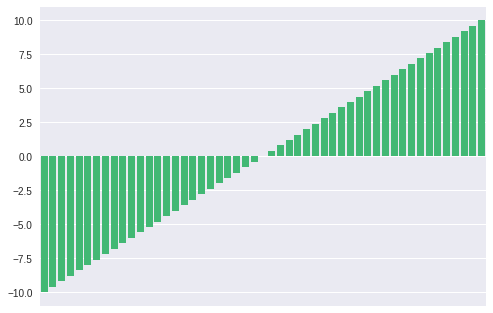

In [74]:
g = sns.barplot(torch.arange(0, 51).numpy(), z, color="#2ecc71")
g.set(xticklabels=[]);

In [65]:
q

array([ 0.00773177, -0.00064816,  0.04333508, -0.01434487], dtype=float32)

In [67]:
z2 = c51(Variable(process_state(state))).squeeze(0).data

## Calculating new loss using cross entropy between distributions

In [92]:
select_action(c51, state, projection_dist, 0, env)

2

In [91]:
def select_action(c51, state, projection_dist, epsilon, env):
    if epsilon > random.random():
        return env.action_space.sample()
    
    q_dists = c51(Variable(process_state(state), volatile=True)).squeeze(0).data
    q_vals = (q_dists * projection_dist).sum(1)
    return int(q_vals.max(0)[1]) # pick highest Q_val

In [17]:
qdists = c51(Variable(process_state(state)))[:, 0]
target_qdists = c51(Variable(process_state(state))).detach()[:, 0]
targets = 1 + (0.99 + target_qdists)

normal pytorch crossentropy loss expects our targets as class labels rather than distributions so we will have to make our own

In [27]:
def cross_entropy(output, targets):
    """
    cross entropy loss between distributions.
    input and targets of (batch, distribution).
    """
    return -(targets * torch.log(output)).sum(dim=1).mean())

In [32]:
cross_entropy(qdists, qdists)

Variable containing:
 204.4692
[torch.FloatTensor of size 1]